In [69]:
import numpy as np
import sympy as sp
from control import matlab as m
from sympy.abc import s, z
from utils.units import basis, u

In [70]:
from utils.units.sympy_helpers import without_units
def usubs(var, val, expr):
    return without_units(expr,
        lambda dummify, expr: expr.subs(
            var, dummify(val)))

def var_in(var, unit, expr):
    return usubs(var, var/unit, expr)

In [71]:
nu = basis()
nu

NumericalBasis(mapper=QuantityMapper(salt=-4213035831237403819), proxy_system=<UnitSystem: (meter, kilogram, second, ampere, mole, candela, kelvin)>)

In [72]:
gp = 0.00056858/(s**2+0.3744*s+0.001464)
gp = var_in(s, u.rad/u.s, gp)

In [73]:
gp

0.00056858/(0.001464 + 0.3744*second*s/radian + second**2*s**2/radian**2)

In [74]:
from utils.ctrl import expr2sys

def my_expr2sys(expr, var, tf=None):
    return expr2sys(nu.to_numeric(expr, as_expr=True), var, tf)

gp_tf = my_expr2sys(gp, s)
gp_tf

TransferFunction(array([0.00056858]), array([9.28345031e+03, 3.60736883e+01, 1.46400000e-03]))

In [75]:
gpcl_tf = m.feedback(gp_tf)
gpcl_tf

TransferFunction(array([0.00056858]), array([9.28345031e+03, 3.60736883e+01, 2.03258000e-03]))

In [76]:
from utils.ctrl import nu_stepinfo
dt = nu_stepinfo(
    nu, u.s, 1, m.stepinfo(gpcl_tf, SettlingTimeThreshold=.05)
)["SettlingTime"] / 5
dt

111.438092101955*second

In [77]:
gp_dtf = m.c2d(gp_tf, nu[dt])
gp_dtf

TransferFunction(array([0.13565111, 0.00269607]), array([ 1.00000000e+00, -6.43778762e-01,  7.14738005e-17]), 10737.134086129885)

In [78]:
from utils.ctrl import siso_numden
from control import TransferFunction
from utils.ratpolys import poly_eval

def deadbeat(num, den):
    return den, [poly_eval(num, 1)] + [-n for n in num]

def deadbeat_sys(sys):
    return TransferFunction(
        *deadbeat(*siso_numden(sys.minreal())),
        sys.dt)

# essentially an S combinator
def with_deadbeat(sys):
    return sys*deadbeat_sys(sys)

In [84]:
gc_dtf = deadbeat_sys(gp_dtf)
gc_dtf

TransferFunction(array([ 1.00000000e+00, -6.43778762e-01,  7.14738005e-17]), array([ 0.13834718, -0.13565111, -0.00269607]), 10737.134086129885)

In [85]:
gcl_dtf = m.feedback(gp_dtf*gc_dtf)
gcl_dtf.minreal()

TransferFunction(array([0.98051227, 0.01948773]), array([1., 0., 0.]), 10737.134086129885)

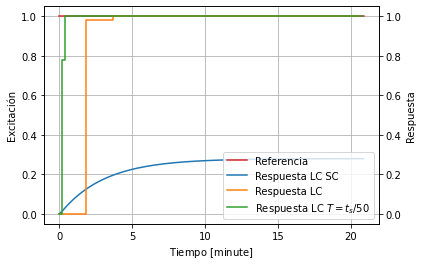

In [86]:
from utils.mpl import io_axes, nu_twinx_axes
from utils.ctrl import step_resp

fig, (ax_e, ax_r), next_color, set_gain_and_legend_loc = io_axes()
plot_step, plot_ref = step_resp(ax_e.plot, ax_r.plot, next_color)

set_time_title, set_e_title, set_r_title = nu_twinx_axes(
    nu, ax_e, ax_r, u.minutes, 1, 1
)

plot_step(gpcl_tf, label="Respuesta LC SC")
plot_step(gcl_dtf, label="Respuesta LC")
plot_step(
    m.feedback(with_deadbeat(m.c2d(gp_tf, nu[dt]/10))),
    label="Respuesta LC $T=t_s/50$")
plot_ref(label="Referencia")

set_time_title("Tiempo")
set_e_title("Excitación")
set_r_title("Respuesta")
ax_e.grid()
set_gain_and_legend_loc(gcl_dtf.dcgain(), "lower right")

#fig.savefig(out_dir / "1p3_resp.svg")